# Virtual the growth plate from single-cell transcriptomic data

In [1]:
import scanpy as sc, anndata as ad

import openTSNE
import boundary_utils as bu

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

In [2]:
filename = '../data/growth_plate.h5ad'
adata = sc.read_h5ad(filename)
adata

AnnData object with n_obs × n_vars = 3474 × 16537
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'CellType', 'ident', 'monocle3_pseudotime'
    var: 'name'
    obsm: 'X_pca', 'X_umap'

Where n_obs × n_vars = 3474 × 40632 -> 3474 and 40632 genes. PCA components and pseudotime value are defined for each cell

In [3]:
pca_data = adata.obsm['X_pca']
pca_data.shape

(3474, 50)

In [4]:
pseudotime = adata.obs['monocle3_pseudotime']
pseudotime.shape

(3474,)

In [5]:
adata.obs['CellType'] = adata.obs['CellType'].cat.remove_unused_categories()

Parameters of the circle boundary function which confines TSNE output

In [6]:
radius = 5
y_center = 2.5
n_slices = 50

## Bounded embedding during TSNE dimensionality reduction

Adaptation of the "t-SNE Animations" tutorial from creators of openTSNE:

https://github.com/pavlin-policar/openTSNE/blob/master/examples/05_animation.ipynb

In [7]:
x = pca_data

### TSNE without confined embedding

In [8]:
def set_boundary_embedding(emb, embeddings):
    embeddings.append(np.array(emb))

We pass a callback that will take the current embedding, make a copy (this is important because the embedding is changed inplace during optimization) and add it to a list. We can also specify how often the callbacks should be called. In this instance, we'll call it at every iteration.

In [9]:
embeddings = []

tsne = openTSNE.TSNE(
    perplexity=50, metric="cosine", n_jobs=32, verbose=True,
    # The embedding will be appended to the list we defined above, make sure we copy the
    # embedding, otherwise the same object reference will be stored for every iteration
    callbacks=lambda it, err, emb: set_boundary_embedding(emb, embeddings),
    # This should be done on every iteration
    callbacks_every_iters=1,
)

In [10]:
%time tsne_embedding = tsne.fit(x)

--------------------------------------------------------------------------------
TSNE(callbacks=<function <lambda> at 0x7f67876d7160>, callbacks_every_iters=1,
     metric='cosine', n_jobs=32, perplexity=50, verbose=True)
--------------------------------------------------------------------------------
===> Finding 150 nearest neighbors using Annoy approximate search using cosine distance...
   --> Time elapsed: 0.40 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.09 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.02 seconds
===> Running optimization with exaggeration=12.00, lr=289.50 for 250 iterations...
Iteration   50, KL divergence 3.8332, 50 iterations in 0.3153 sec
Iteration  100, KL divergence 3.5900, 50 iterations in 0.2578 sec
Iteration  150, KL divergence 3.5899, 50 iterations in 0.2613 sec
Iteration  200, KL divergence 3.5900, 50 iterations in 0.2621 sec
Iteration  250, KL divergence 3.5900, 50 iterations in 0.2616 sec
   --> Tim

In [11]:
adata.obsm['X_tsne'] = embeddings[-1]

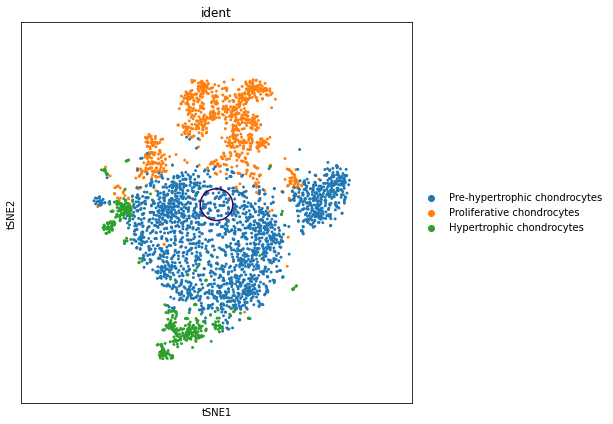

In [12]:
fig, ax = plt.subplots(figsize=(7, 7))

a = np.linspace(-60, 60, 1000)
b = np.linspace(-60, 60, 1000)
A, B = np.meshgrid(a,b)

ax.contour(A, B, bu.boundary_circle(A, B, radius = radius, y_center = y_center) ,[0])

sc.pl.tsne(adata, color='ident', ax=ax)

ax.set_aspect('equal')

### TSNE with circular embedding

In [13]:
buondary_function = lambda x , y : bu.boundary_circle(x, y, radius = radius, y_center = y_center)

def set_boundary_embedding(emb, embeddings, boundary_function):
    outside_boundary = buondary_function(emb[:,0], emb[:,1]) < 0
    if any(outside_boundary):
        output = list(map(lambda point : bu.closest_point_in_function(point, buondary_function), emb[outside_boundary]))
        emb[outside_boundary] = np.array(output)
    embeddings.append(np.array(emb))

We pass a callback that will take the current embedding, make a copy (this is important because the embedding is changed inplace during optimization) and add it to a list. We can also specify how often the callbacks should be called. In this instance, we'll call it at every iteration.

In [14]:
embeddings = []

tsne = openTSNE.TSNE(
    perplexity=50, metric="cosine", n_jobs=32, verbose=True,
    # The embedding will be appended to the list we defined above, make sure we copy the
    # embedding, otherwise the same object reference will be stored for every iteration
    callbacks=lambda it, err, emb: set_boundary_embedding(emb, embeddings, buondary_function),
    # This should be done on every iteration
    callbacks_every_iters=1,
)

In [15]:
%time tsne_embedding = tsne.fit(x)

--------------------------------------------------------------------------------
TSNE(callbacks=<function <lambda> at 0x7f67876e53a0>, callbacks_every_iters=1,
     metric='cosine', n_jobs=32, perplexity=50, verbose=True)
--------------------------------------------------------------------------------
===> Finding 150 nearest neighbors using Annoy approximate search using cosine distance...
   --> Time elapsed: 0.39 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.05 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.01 seconds
===> Running optimization with exaggeration=12.00, lr=289.50 for 250 iterations...
Iteration   50, KL divergence 3.8302, 50 iterations in 0.3589 sec
Iteration  100, KL divergence 3.5887, 50 iterations in 0.3150 sec
Iteration  150, KL divergence 3.5886, 50 iterations in 0.3159 sec
Iteration  200, KL divergence 3.5886, 50 iterations in 0.4188 sec
Iteration  250, KL divergence 3.5886, 50 iterations in 0.4796 sec
   --> Tim

In [16]:
adata.obsm['X_tsne'] = embeddings[-1]

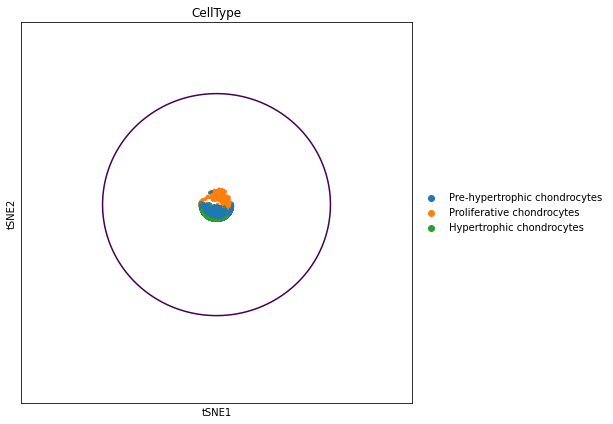

In [17]:
fig, ax = plt.subplots(figsize=(7, 7))

a = np.linspace(-60, 60, 1000)
b = np.linspace(-60, 60, 1000)
A, B = np.meshgrid(a,b)

ax.contour(A, B, bu.boundary_circle(A, B, radius = 35, y_center = 2.5) ,[0])

sc.pl.tsne(adata, color='CellType', ax=ax)

ax.set_aspect('equal')

Plotting a 3D Scatter Plot in Seaborn

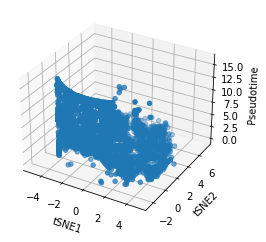

In [18]:
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = adata.obsm['X_tsne'][:,0]
y = adata.obsm['X_tsne'][:,1]
z = adata.obs['monocle3_pseudotime']

ax.set_xlabel("tSNE1")
ax.set_ylabel("tSNE2")
ax.set_zlabel("Pseudotime")

ax.scatter(x, y, z)

### TSNE slices with circular embedding

cut is used to bin pandas DataFrame and specifically define the bin edges. There is no guarantee about the distribution of items in each bin. In fact, you can define bins in such a way that no items are included in a bin or nearly all items are in a single bin.

https://pbpython.com/pandas-qcut-cut.html

In [19]:
adata.obs['cut_pseudotime'] = pd.cut(adata.obs['monocle3_pseudotime'], bins=n_slices, include_lowest=True)

After binning the adata object, we separate each bin and run the TSNE dimentionsality reduction with circular embedding. After, the output of the embedded TSNEs will be concatenated and merged.

 - Concatenation is when we keep all sub elements of each object, and stack these elements in an ordered way.

 - Merging is combining a set of collections into one resulting collection which contains elements from the objects.

https://anndata.readthedocs.io/en/latest/concatenation.html

In [20]:
df_tsne = pd.DataFrame(columns = ['idx', 'X_tsne_sliced'])

adatas = []

for count, item in enumerate(adata.obs.groupby('cut_pseudotime').indices.items()):
    print(f'Slice number: {count}')
    group, idx = item
    
    if idx.size == 0:
            df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': []}, ignore_index=True)
    else:
        sub_adata = adata[idx].copy()
    
        bu.circular_openTSNE(sub_adata, radius = radius, y_center = y_center)

        df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': sub_adata.obsm['X_tsne']}, ignore_index=True)
        
        adatas.append(sub_adata)

Slice number: 0
--------------------------------------------------------------------------------
TSNE(callbacks=<function circular_openTSNE.<locals>.<lambda> at 0x7f677f0e7700>,
     callbacks_every_iters=1, metric='cosine', n_jobs=32, perplexity=50,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 150 nearest neighbors using exact search using cosine distance...
   --> Time elapsed: 0.04 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.01 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 2.1435, 50 iterations in 0.1467 sec
Iteration  100, KL divergence 2.0284, 50 iterations in 0.0783 sec
Iteration  150, KL divergence 1.9399, 50 iterations in 0.0680 sec
Iteration  200, KL divergence 2.0063, 50 iterations in 0.0672 sec
Iteration  250, KL divergence 1.9878, 50

Perplexity value 50 is too high. Using perplexity 13.67 instead


Iteration  450, KL divergence 0.1282, 50 iterations in 0.0674 sec
Iteration  500, KL divergence 0.1282, 50 iterations in 0.0682 sec
   --> Time elapsed: 0.75 seconds
Slice number: 14
--------------------------------------------------------------------------------
TSNE(callbacks=<function circular_openTSNE.<locals>.<lambda> at 0x7f677f007700>,
     callbacks_every_iters=1, metric='cosine', n_jobs=32, perplexity=50,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 41 nearest neighbors using exact search using cosine distance...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.7503, 50 iterations in 0.2437 sec
Iteration  100, KL divergence 1.7062, 50 iterations in 0.1871 sec
Iterat

Perplexity value 50 is too high. Using perplexity 1.67 instead


Iteration  350, KL divergence 0.0142, 50 iterations in 0.0328 sec
Iteration  400, KL divergence 0.0141, 50 iterations in 0.0308 sec
Iteration  450, KL divergence 0.0141, 50 iterations in 0.0358 sec
Iteration  500, KL divergence 0.0141, 50 iterations in 0.0307 sec
   --> Time elapsed: 0.31 seconds
Slice number: 17
--------------------------------------------------------------------------------
TSNE(callbacks=<function circular_openTSNE.<locals>.<lambda> at 0x7f677efe23a0>,
     callbacks_every_iters=1, metric='cosine', n_jobs=32, perplexity=50,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 5 nearest neighbors using exact search using cosine distance...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iterati

Perplexity value 50 is too high. Using perplexity 6.00 instead


Iteration  500, KL divergence 0.9781, 50 iterations in 0.1653 sec
   --> Time elapsed: 1.65 seconds
Slice number: 18
Slice number: 19
Slice number: 20
--------------------------------------------------------------------------------
TSNE(callbacks=<function circular_openTSNE.<locals>.<lambda> at 0x7f677efe2820>,
     callbacks_every_iters=1, metric='cosine', n_jobs=32, perplexity=50,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 18 nearest neighbors using exact search using cosine distance...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.5404, 50 iterations in 0.1096 sec
Iteration  100, KL divergence 1.6658, 50 iterations in 0.1173 sec
Iteration  150, KL divergence 1.4605, 

Perplexity value 50 is too high. Using perplexity 14.33 instead


Iteration  450, KL divergence 0.1360, 50 iterations in 0.1787 sec
Iteration  500, KL divergence 0.1402, 50 iterations in 0.1693 sec
   --> Time elapsed: 1.92 seconds
Slice number: 21
--------------------------------------------------------------------------------
TSNE(callbacks=<function circular_openTSNE.<locals>.<lambda> at 0x7f677efe2d30>,
     callbacks_every_iters=1, metric='cosine', n_jobs=32, perplexity=50,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 43 nearest neighbors using exact search using cosine distance...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.4464, 50 iterations in 0.2496 sec
Iteration  100, KL divergence 1.3810, 50 iterations in 0.1629 sec
Iterat

Perplexity value 50 is too high. Using perplexity 9.67 instead


Iteration  500, KL divergence 0.3089, 50 iterations in 0.2758 sec
   --> Time elapsed: 2.85 seconds
Slice number: 22
--------------------------------------------------------------------------------
TSNE(callbacks=<function circular_openTSNE.<locals>.<lambda> at 0x7f677efec040>,
     callbacks_every_iters=1, metric='cosine', n_jobs=32, perplexity=50,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 29 nearest neighbors using exact search using cosine distance...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.5828, 50 iterations in 0.1369 sec
Iteration  100, KL divergence 1.6980, 50 iterations in 0.1347 sec
Iteration  150, KL divergence 1.4425, 50 iterations in 0.1460 sec
Iterat

Perplexity value 50 is too high. Using perplexity 3.33 instead


Iteration  500, KL divergence 0.2231, 50 iterations in 1.6034 sec
   --> Time elapsed: 15.72 seconds
Slice number: 24
--------------------------------------------------------------------------------
TSNE(callbacks=<function circular_openTSNE.<locals>.<lambda> at 0x7f677efecdc0>,
     callbacks_every_iters=1, metric='cosine', n_jobs=32, perplexity=50,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 10 nearest neighbors using exact search using cosine distance...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.4220, 50 iterations in 0.0770 sec
Iteration  100, KL divergence 1.7111, 50 iterations in 0.0927 sec
Iteration  150, KL divergence 1.7194, 50 iterations in 0.0971 sec
Itera

Perplexity value 50 is too high. Using perplexity 3.00 instead


Iteration  500, KL divergence 1.3926, 50 iterations in 0.2757 sec
   --> Time elapsed: 2.67 seconds
Slice number: 25
--------------------------------------------------------------------------------
TSNE(callbacks=<function circular_openTSNE.<locals>.<lambda> at 0x7f677efec1f0>,
     callbacks_every_iters=1, metric='cosine', n_jobs=32, perplexity=50,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 9 nearest neighbors using exact search using cosine distance...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.4950, 50 iterations in 0.0732 sec
Iteration  100, KL divergence 1.4965, 50 iterations in 0.0785 sec
Iteration  150, KL divergence 1.7169, 50 iterations in 0.0795 sec
Iterati

Perplexity value 50 is too high. Using perplexity 3.33 instead


Iteration  500, KL divergence 1.0322, 50 iterations in 0.2560 sec
   --> Time elapsed: 2.44 seconds
Slice number: 26
--------------------------------------------------------------------------------
TSNE(callbacks=<function circular_openTSNE.<locals>.<lambda> at 0x7f677efec9d0>,
     callbacks_every_iters=1, metric='cosine', n_jobs=32, perplexity=50,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 10 nearest neighbors using exact search using cosine distance...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.9682, 50 iterations in 0.0880 sec
Iteration  100, KL divergence 1.4787, 50 iterations in 0.0968 sec
Iteration  150, KL divergence 1.4174, 50 iterations in 0.0868 sec
Iterat

Perplexity value 50 is too high. Using perplexity 3.67 instead


Iteration  500, KL divergence 1.2427, 50 iterations in 0.2693 sec
   --> Time elapsed: 2.64 seconds
Slice number: 27
--------------------------------------------------------------------------------
TSNE(callbacks=<function circular_openTSNE.<locals>.<lambda> at 0x7f677efeca60>,
     callbacks_every_iters=1, metric='cosine', n_jobs=32, perplexity=50,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 11 nearest neighbors using exact search using cosine distance...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.4392, 50 iterations in 0.1268 sec
Iteration  100, KL divergence 1.6675, 50 iterations in 0.1244 sec
Iteration  150, KL divergence 1.5283, 50 iterations in 0.0992 sec
Iterat

Perplexity value 50 is too high. Using perplexity 7.00 instead


Iteration  500, KL divergence 0.1679, 50 iterations in 0.0546 sec
   --> Time elapsed: 0.66 seconds
Slice number: 29
Slice number: 30
--------------------------------------------------------------------------------
TSNE(callbacks=<function circular_openTSNE.<locals>.<lambda> at 0x7f677f0008b0>,
     callbacks_every_iters=1, metric='cosine', n_jobs=32, perplexity=50,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 21 nearest neighbors using exact search using cosine distance...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.5451, 50 iterations in 0.1213 sec
Iteration  100, KL divergence 1.4737, 50 iterations in 0.1279 sec
Iteration  150, KL divergence 1.6026, 50 iterations in 

Perplexity value 50 is too high. Using perplexity 8.67 instead


Iteration  500, KL divergence 0.2372, 50 iterations in 0.2245 sec
   --> Time elapsed: 2.22 seconds
Slice number: 31
--------------------------------------------------------------------------------
TSNE(callbacks=<function circular_openTSNE.<locals>.<lambda> at 0x7f677f000b80>,
     callbacks_every_iters=1, metric='cosine', n_jobs=32, perplexity=50,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 26 nearest neighbors using exact search using cosine distance...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.6984, 50 iterations in 0.1296 sec
Iteration  100, KL divergence 1.4655, 50 iterations in 0.1362 sec
Iteration  150, KL divergence 1.5968, 50 iterations in 0.1301 sec
Iterat

Perplexity value 50 is too high. Using perplexity 14.00 instead


Iteration  500, KL divergence 0.2294, 50 iterations in 0.2394 sec
   --> Time elapsed: 2.40 seconds
Slice number: 32
Slice number: 33
--------------------------------------------------------------------------------
TSNE(callbacks=<function circular_openTSNE.<locals>.<lambda> at 0x7f677f000ca0>,
     callbacks_every_iters=1, metric='cosine', n_jobs=32, perplexity=50,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 42 nearest neighbors using exact search using cosine distance...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.4934, 50 iterations in 0.2446 sec
Iteration  100, KL divergence 1.4839, 50 iterations in 0.1684 sec
Iteration  150, KL divergence 1.3199, 50 iterations in 

Perplexity value 50 is too high. Using perplexity 15.33 instead


Iteration  500, KL divergence 0.2013, 50 iterations in 0.3883 sec
   --> Time elapsed: 3.71 seconds
Slice number: 34
--------------------------------------------------------------------------------
TSNE(callbacks=<function circular_openTSNE.<locals>.<lambda> at 0x7f677f000d30>,
     callbacks_every_iters=1, metric='cosine', n_jobs=32, perplexity=50,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 46 nearest neighbors using exact search using cosine distance...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.6044, 50 iterations in 0.2702 sec
Iteration  100, KL divergence 1.5404, 50 iterations in 0.1915 sec
Iteration  150, KL divergence 1.6388, 50 iterations in 0.1884 sec
Iterat

Perplexity value 50 is too high. Using perplexity 12.33 instead


Iteration  500, KL divergence 0.2817, 50 iterations in 0.3109 sec
   --> Time elapsed: 3.35 seconds
Slice number: 35
--------------------------------------------------------------------------------
TSNE(callbacks=<function circular_openTSNE.<locals>.<lambda> at 0x7f6753ea70d0>,
     callbacks_every_iters=1, metric='cosine', n_jobs=32, perplexity=50,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 37 nearest neighbors using exact search using cosine distance...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.3409, 50 iterations in 0.1747 sec
Iteration  100, KL divergence 1.4286, 50 iterations in 0.1569 sec
Iteration  150, KL divergence 1.3598, 50 iterations in 0.1695 sec
Iterat

Perplexity value 50 is too high. Using perplexity 1.67 instead


Iteration  500, KL divergence 0.2071, 50 iterations in 0.2340 sec
   --> Time elapsed: 2.48 seconds
Slice number: 36
--------------------------------------------------------------------------------
TSNE(callbacks=<function circular_openTSNE.<locals>.<lambda> at 0x7f6753ea7f70>,
     callbacks_every_iters=1, metric='cosine', n_jobs=32, perplexity=50,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 5 nearest neighbors using exact search using cosine distance...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 2.3318, 50 iterations in 0.0636 sec
Iteration  100, KL divergence 1.2453, 50 iterations in 0.0665 sec
Iteration  150, KL divergence 1.6877, 50 iterations in 0.0725 sec
Iterati

Perplexity value 50 is too high. Using perplexity 3.00 instead


Iteration  450, KL divergence 1.1893, 50 iterations in 0.1707 sec
Iteration  500, KL divergence 1.0494, 50 iterations in 0.1619 sec
   --> Time elapsed: 1.65 seconds
Slice number: 37
--------------------------------------------------------------------------------
TSNE(callbacks=<function circular_openTSNE.<locals>.<lambda> at 0x7f6753ea7670>,
     callbacks_every_iters=1, metric='cosine', n_jobs=32, perplexity=50,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 9 nearest neighbors using exact search using cosine distance...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.6734, 50 iterations in 0.0808 sec
Iteration  100, KL divergence 1.5793, 50 iterations in 0.0801 sec
Iterati

Perplexity value 50 is too high. Using perplexity 7.33 instead


Iteration  300, KL divergence 0.0067, 50 iterations in 0.0313 sec
Iteration  350, KL divergence 0.0066, 50 iterations in 0.0342 sec
Iteration  400, KL divergence 0.0066, 50 iterations in 0.0304 sec
Iteration  450, KL divergence 0.0065, 50 iterations in 0.0311 sec
Iteration  500, KL divergence 0.0067, 50 iterations in 0.0392 sec
   --> Time elapsed: 0.34 seconds
Slice number: 39
Slice number: 40
--------------------------------------------------------------------------------
TSNE(callbacks=<function circular_openTSNE.<locals>.<lambda> at 0x7f6753ea7ee0>,
     callbacks_every_iters=1, metric='cosine', n_jobs=32, perplexity=50,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 22 nearest neighbors using exact search using cosine distance...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> R

Perplexity value 50 is too high. Using perplexity 12.00 instead


Iteration  350, KL divergence 0.0098, 50 iterations in 0.0334 sec
Iteration  400, KL divergence 0.0097, 50 iterations in 0.0303 sec
Iteration  450, KL divergence 0.0100, 50 iterations in 0.0327 sec
Iteration  500, KL divergence 0.0100, 50 iterations in 0.0318 sec
   --> Time elapsed: 0.32 seconds
Slice number: 42
--------------------------------------------------------------------------------
TSNE(callbacks=<function circular_openTSNE.<locals>.<lambda> at 0x7f6753e5f1f0>,
     callbacks_every_iters=1, metric='cosine', n_jobs=32, perplexity=50,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 36 nearest neighbors using exact search using cosine distance...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iterat

Perplexity value 50 is too high. Using perplexity 12.00 instead


Iteration  500, KL divergence 0.2499, 50 iterations in 0.3248 sec
   --> Time elapsed: 3.11 seconds
Slice number: 43
--------------------------------------------------------------------------------
TSNE(callbacks=<function circular_openTSNE.<locals>.<lambda> at 0x7f6753e5f700>,
     callbacks_every_iters=1, metric='cosine', n_jobs=32, perplexity=50,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 36 nearest neighbors using exact search using cosine distance...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.5267, 50 iterations in 0.1627 sec
Iteration  100, KL divergence 1.6582, 50 iterations in 0.1574 sec
Iteration  150, KL divergence 1.5786, 50 iterations in 0.1571 sec
Iterat

Perplexity value 50 is too high. Using perplexity 7.00 instead


Iteration  450, KL divergence 0.0458, 50 iterations in 0.0364 sec
Iteration  500, KL divergence 0.0457, 50 iterations in 0.0336 sec
   --> Time elapsed: 0.49 seconds
Slice number: 45
Slice number: 46
--------------------------------------------------------------------------------
TSNE(callbacks=<function circular_openTSNE.<locals>.<lambda> at 0x7f6753e5f9d0>,
     callbacks_every_iters=1, metric='cosine', n_jobs=32, perplexity=50,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 21 nearest neighbors using exact search using cosine distance...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.7183, 50 iterations in 0.1223 sec
Iteration  100, KL divergence 1.5236, 50 iterations in 

Perplexity value 50 is too high. Using perplexity 15.67 instead


--------------------------------------------------------------------------------
TSNE(callbacks=<function circular_openTSNE.<locals>.<lambda> at 0x7f6753e5f820>,
     callbacks_every_iters=1, metric='cosine', n_jobs=32, perplexity=50,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 47 nearest neighbors using exact search using cosine distance...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.3963, 50 iterations in 0.2347 sec
Iteration  100, KL divergence 1.3272, 50 iterations in 0.1712 sec
Iteration  150, KL divergence 1.5125, 50 iterations in 0.1739 sec
Iteration  200, KL divergence 1.5936, 50 iterations in 0.1619 sec
Iteration  250, KL divergence 1.5597, 50 iterations in 0.

Perplexity value 50 is too high. Using perplexity 2.33 instead


Iteration  500, KL divergence 0.3001, 50 iterations in 0.3416 sec
   --> Time elapsed: 3.46 seconds
Slice number: 48
--------------------------------------------------------------------------------
TSNE(callbacks=<function circular_openTSNE.<locals>.<lambda> at 0x7f6753e70040>,
     callbacks_every_iters=1, metric='cosine', n_jobs=32, perplexity=50,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 7 nearest neighbors using exact search using cosine distance...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.2682, 50 iterations in 0.0762 sec
Iteration  100, KL divergence 1.8054, 50 iterations in 0.0771 sec
Iteration  150, KL divergence 1.1589, 50 iterations in 0.0724 sec
Iterati

In [21]:
sliced_adata = ad.concat(adatas)

## Plotting virtual growth plate

The 'cut_pseudotime' field gave an error while writing the slice_adata object, thus it is deleted

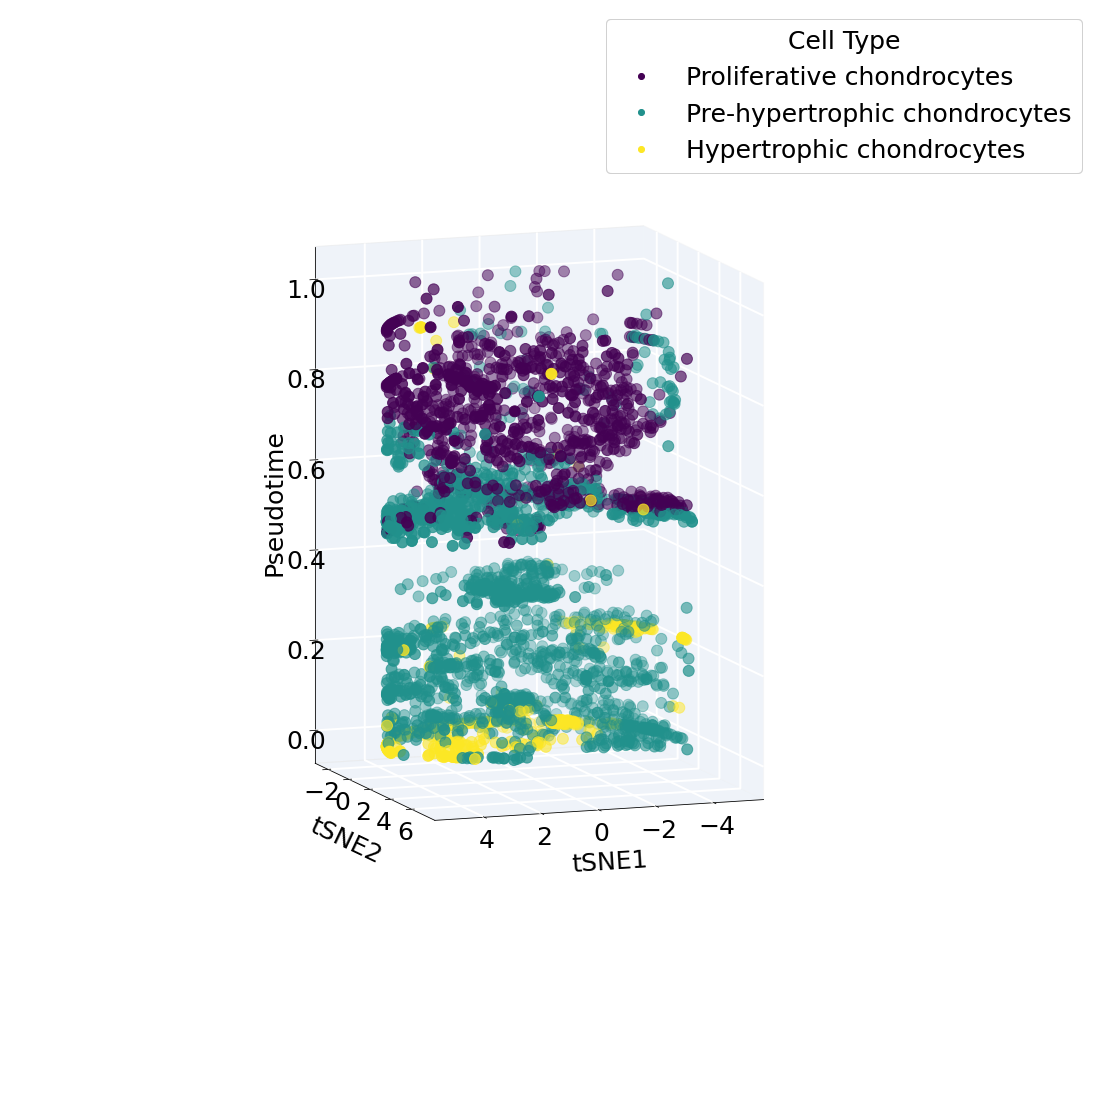

In [22]:
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

width = 20
height = 20
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [width, height]
plt.rcParams.update({'font.size': 25})
plt.rcParams['grid.color'] = 'w'
plt.rcParams['grid.linewidth'] = 2

fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
ax.set_proj_type('ortho')

x = sliced_adata.obsm['X_tsne'][:,0]
y = sliced_adata.obsm['X_tsne'][:,1]
norm_pseudo = sliced_adata.obs['monocle3_pseudotime']/sliced_adata.obs['monocle3_pseudotime'].max()
z = 1 - np.cbrt(norm_pseudo)
celltype = sliced_adata.obs['CellType']
celltype_factorized, celltype_uniques = pd.factorize( celltype )

col = ['blue', 'green', 'red']
color = pd.Index(col)[celltype_factorized]

ax.set_xlabel("tSNE1", labelpad=30)
ax.set_ylabel("tSNE2", labelpad=30)
ax.set_zlabel("Pseudotime", labelpad=30)

scatter = ax.scatter(x, y, z, s = 120, c = celltype_factorized)

"""                                                                                                                                                    
Scaling is done from here...                                                                                                                           
"""
x_scale=1
y_scale=1
z_scale=2

scale=np.diag([x_scale, y_scale, z_scale, 1.0])
scale=scale*(1.0/scale.max())
scale[3,3]=1.0

def short_proj():
  return np.dot(Axes3D.get_proj(ax), scale)

ax.get_proj=short_proj
"""                                                                                                                                                    
to here                                                                                                                                                
"""

legend_labelled = (scatter.legend_elements()[0],list(celltype.unique()))

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*legend_labelled,
                    loc="upper right", title="Cell Type")
ax.add_artist(legend1)

# ax.legend()

ax.view_init(10, 70)

# Now set color to white (or whatever is "invisible")
# pane_color = [229/255,236/255,246/255]
pane_color = [224/255,233/255,245/255]
ax.xaxis.pane.set_facecolor(pane_color)
ax.yaxis.pane.set_facecolor(pane_color)
ax.zaxis.pane.set_facecolor(pane_color)

# plt.savefig(f'plots/celltypes/virtual-growth_plate_r{radius}_s{n_slices}_cbrt_legend.svg')

/opt/conda/envs/sc-env/lib/python3.8/site-packages/matplotlib/collections.py:1120: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


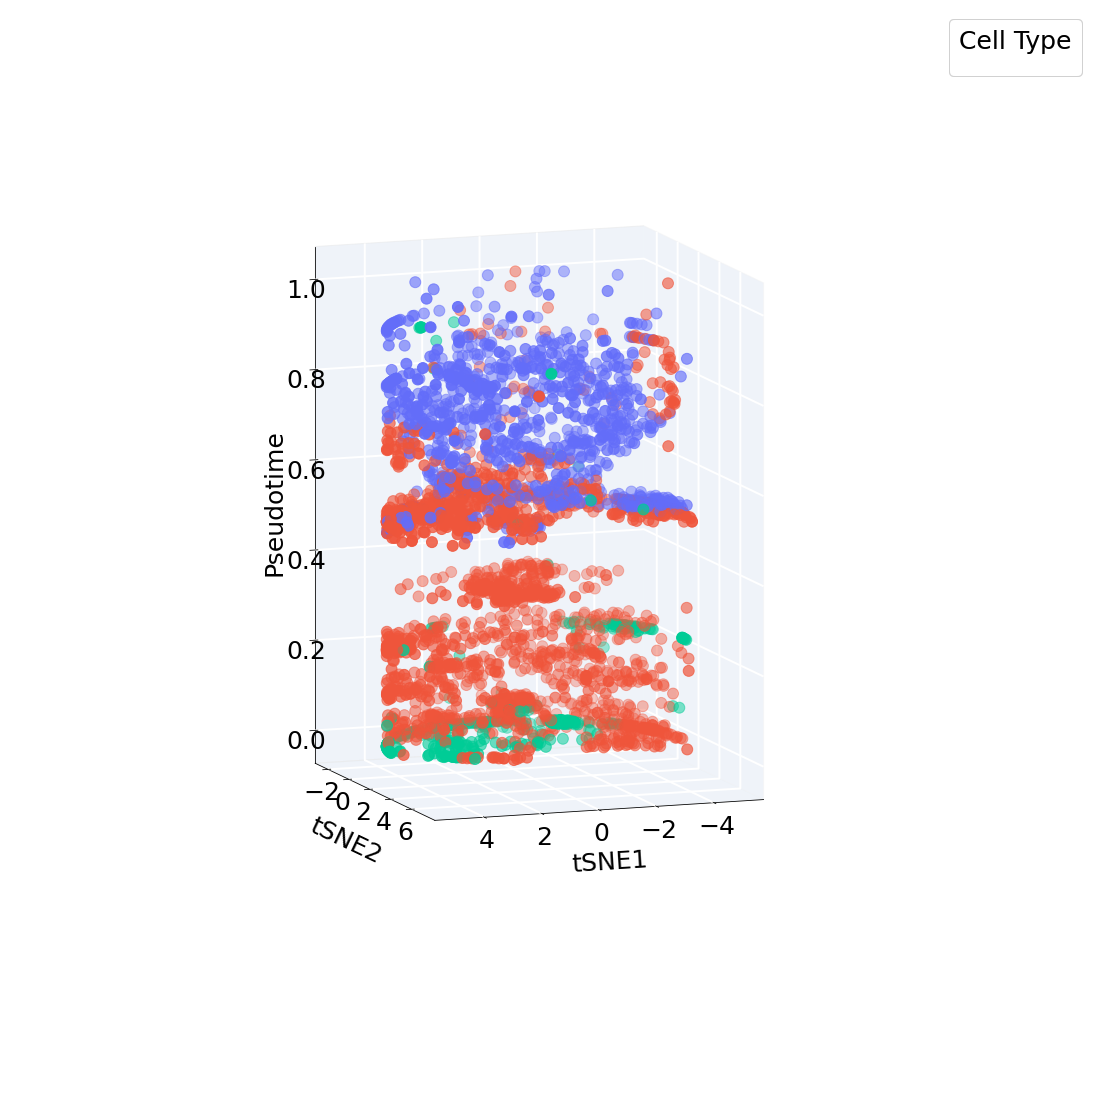

In [23]:
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

width = 20
height = 20
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [width, height]
plt.rcParams.update({'font.size': 25})
plt.rcParams['grid.color'] = 'w'
plt.rcParams['grid.linewidth'] = 2

fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
ax.set_proj_type('ortho')

x = sliced_adata.obsm['X_tsne'][:,0]
y = sliced_adata.obsm['X_tsne'][:,1]
norm_pseudo = sliced_adata.obs['monocle3_pseudotime']/sliced_adata.obs['monocle3_pseudotime'].max()
z = 1 - np.cbrt(norm_pseudo)
celltype = sliced_adata.obs['CellType']
celltype_factorized, celltype_uniques = pd.factorize( celltype )

col = ['#636dfa', '#ef553b', '#00cc96']
color = pd.Index(col)[celltype_factorized]

ax.set_xlabel("tSNE1", labelpad=30)
ax.set_ylabel("tSNE2", labelpad=30)
ax.set_zlabel("Pseudotime", labelpad=30)

scatter = ax.scatter(x, y, z, s = 120, c = color)

"""                                                                                                                                                    
Scaling is done from here...                                                                                                                           
"""
x_scale=1
y_scale=1
z_scale=2

scale=np.diag([x_scale, y_scale, z_scale, 1.0])
scale=scale*(1.0/scale.max())
scale[3,3]=1.0

def short_proj():
  return np.dot(Axes3D.get_proj(ax), scale)

ax.get_proj=short_proj
"""                                                                                                                                                    
to here                                                                                                                                                
"""

legend_labelled = (scatter.legend_elements()[0],list(celltype.unique()))

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*legend_labelled,
                    loc="upper right", title="Cell Type")
ax.add_artist(legend1)

# ax.legend()

ax.view_init(10, 70)

# Now set color to white (or whatever is "invisible")
# pane_color = [229/255,236/255,246/255]
pane_color = [224/255,233/255,245/255]
ax.xaxis.pane.set_facecolor(pane_color)
ax.yaxis.pane.set_facecolor(pane_color)
ax.zaxis.pane.set_facecolor(pane_color)

# plt.savefig(f'plots/celltypes/virtual-growth_plate_r{radius}_s{n_slices}_cbrt_color.svg')

In [28]:
#sliced_adata.obs = sliced_adata.obs.drop(labels='cut_pseudotime', axis=1)

In [ ]:
sliced_adata

AnnData object with n_obs × n_vars = 3474 × 16537
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'CellType', 'ident', 'monocle3_pseudotime'
    obsm: 'X_pca', 'X_umap', 'X_tsne'

In [27]:
sliced_adata.write('../data/sliced_adata.h5ad')

... storing 'orig.ident' as categorical
... storing 'CellType' as categorical
... storing 'ident' as categorical


In [71]:
import plotly.express as px

x = sliced_adata.obsm['X_tsne'][:,0]
y = sliced_adata.obsm['X_tsne'][:,1]
norm_pseudo = sliced_adata.obs['monocle3_pseudotime']/sliced_adata.obs['monocle3_pseudotime'].max()
z = 1 - np.cbrt(norm_pseudo)
color = sliced_adata.obs['CellType']

fig = px.scatter_3d(x=x, y=y, z=z, color=color)
fig.update_traces(marker=dict(size=5))

# eye=dict(x=1.7, y=1.7, z=0.8)
scene=dict(camera=dict(eye=dict(x=0.9, y=1.8, z=0.1), #the default values are 1.25, 1.25, 1.25
                       center=dict(x=0, y=0, z=-0.1)),
           xaxis={'title': {'text': 'TSNE1'}},
           yaxis={'title': {'text': 'TSNE2'}},
           zaxis={'title': {'text': 'Pseudotime'}},
           #a custom aspectratio is defined as follows:
           aspectratio=dict(x=1, y=1, z=1.15)
           )

fig.layout.scene = scene

# fig.write_html(f'plots/celltypes/virtual-growth_plate_r{radius}_s{n_slices}_cbrt.html')